In [1]:
import os
import json
import uuid
import pandas as pd
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio
from torchvision.models import resnet18
from b2aiprep.process import Audio, specgram, plot_spectrogram, plot_waveform
import IPython.display as Ipd
#from torchsummary import summary

import numpy as np
from pydub import AudioSegment
import librosa

/home/p/parsak/.conda/envs/b2ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lib import generate_recording_objects, count_samples, filter_recordings_by_label


root_path = '/data/parsak/stridor/Data files'  # Replace with the actual path to your folders
excel_path = '/data/parsak/stridor/Stridor_Labels (1).xlsx'  # Replace with the actual path to your Excel file
output_csv = 'rec_5_time.csv'  # Desired output CSV file name
output_json = 'rec_5_time.json'  # Desired output JSON file name

# Read the Excel file
patient_status_df = pd.read_excel(excel_path)

#print_once = True
recordings = generate_recording_objects(root_path, patient_status_df, filtered_patiens = ["Patient 1", "Patient 5", "Patient 10"])

# Uncomment the following lines to save to CSV
# save_to_csv(recordings, output_csv)
# print(f"Recording objects have been saved to {output_csv}")

# Uncomment the following lines to save to JSON
# save_to_json(recordings, output_json)
# print(f"Recording objects have been saved to {output_json}")

# Count the samples
no_stridor_count, phonatory_count, non_phonatory_count = count_samples(recordings)
print(f"No-Stridor samples: {no_stridor_count}")
print(f"Phonatory samples: {phonatory_count}")
print(f"Non-Phonatory samples: {non_phonatory_count}")

# Filter the data to only include recordings with recording_label starting with "FIMO"
filtered_data = filter_recordings_by_label(recordings, "FIMO")

df = pd.DataFrame(recordings)

No-Stridor samples: 350
Phonatory samples: 89
Non-Phonatory samples: 267


In [3]:
class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label, classification, mel = False, segment_size=3):
        self.dataframe = dataframe
        self.label = label
        self.classification = classification
        self.mel = mel
        self.segment_size = segment_size
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording', 'recording_label', self.label]
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.labels = dataframe[self.label].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()
        
        if classification == 'stridor**nonstridor':
            self.num_classes = 2
        elif classification == 'nonstridor**phonatory**nonphonatory':
            self.num_classes = 3
        else:
            raise ValueError("Error: type 'stridor**nonstridor' Or 'nonstridor**phonatory**nonphonatory' for classification")
            
        if (label == 'is_stridor' and classification == 'stridor**nonstridor') or (label == 'status' and classification == 'nonstridor**phonatory**nonphonatory'):
            pass
        else:
            raise ValueError("label and classification are NOT match")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        recording_label = self.recording_labels[idx]
        num_classes = self.num_classes
        mel = self.mel

        try:
            audio = Audio.from_file(self.audio_files[idx])
            audio = audio.to_16khz()
            
           
            # get middle K seconds if audio is too long, pad with zeros if it is too short
            if audio.signal.size(0) > self.segment_size * 16000:
                d = (audio.signal.size(0) - self.segment_size * 16000) // 2
                audio.signal = audio.signal[d:d + self.segment_size * 16000]
            else:
                #print("before", audio.signal.size())
                padding_needed = self.segment_size*16000-audio.signal.size(0)
                audio.signal = F.pad(audio.signal, (0, 0, 0, padding_needed)) 
                #audio.signal = torch.nn.functional.pad(audio.signal, (0, self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)
                #print("after",audio.signal.size())
            
            
            win_length = 60
            #print(audio.signal.size(1))
            hop_length = 1
            nfft = int(win_length*16)
            features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft).T
            
            if mel == True:
                mel_transform = T.MelScale(n_mels=50, sample_rate=16000, n_stft=481)
                mel_spec = mel_transform(features_specgram.unsqueeze(0)).squeeze(0)
                mel_spec = 10.0 * torch.log10(torch.maximum(mel_spec, torch.full(mel_spec.size(), fill_value=1e-10)))
                features_specgram = mel_spec
            else:
                features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))
            
            features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

        except Exception as e:
            print(f"Error loading {audio_file}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # Convert the label to a tensor

        
        label = torch.tensor(label, dtype=torch.long)
        label = F.one_hot(label, num_classes=num_classes).float()

        return {'uid': uid, 'signal': features_specgram, 'audio': audio.signal, self.label: label, 'recording_label': recording_label}


dataset: <__main__.MySpecgramDataset object at 0x153065a877d0>
['FEMCthyroid', 'RMO12inch', 'RPAvid', 'DeepAvid', 'FIMCcricoid', 'DeepiPad', 'DeepAvid', 'DeepiPad', 'RMOthyroid', 'RPAvid', '3M', 'RAVID1in', 'RPiPad', 'DeepiPad', 'FEMCthyroid', 'FIMOthyroid'] tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
Label is:  tensor([1., 0.])
the shape is:  torch.Size([512, 512])
the size is:  torch.Size([16, 512, 512])


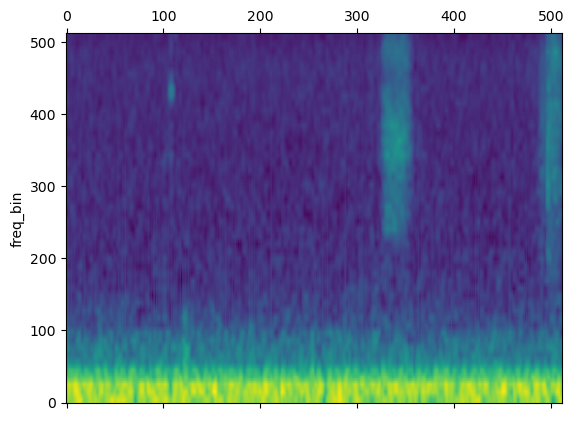

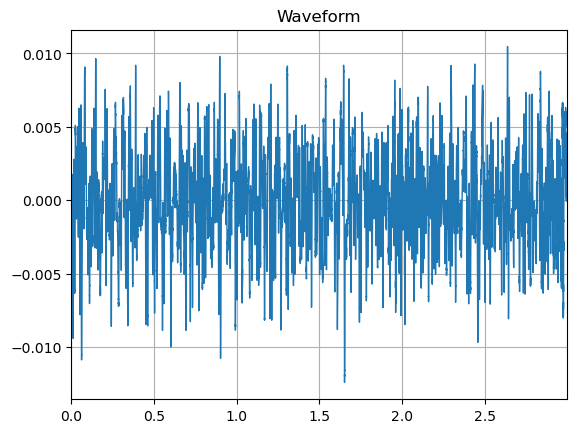

In [11]:

dataset = MySpecgramDataset(df, label = 'is_stridor',  classification = 'stridor**nonstridor', mel = True, segment_size = 3) # classification:  'stridor**nonstridor' Or 'nonstridor**phonatory**nonphonatory' 
label = 'is_stridor' # 'is_stridor' or 'status'
number_classes = 2
#classes = ['no-stridor', 'non-phonatory', 'phonatory']
classes = ['no-stridor', 'stridor']


print(f"dataset: {dataset}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    
    print(batch['recording_label'], batch[label])
    print('Label is: ', batch[label][0])
    for i in range(1,2):
        plot_spectrogram(batch['signal'][i])
        plot_waveform(batch['audio'][i], 16000, title="Waveform", ax=None)
    print("the shape is: ", batch['signal'][0].shape)
    print("the size is: ", batch['signal'].shape)
    break

In [12]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from model import ViT
model = ViT(
    image_size = 512,
    patch_size = 64,
    num_classes = number_classes,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)


cuda


In [ ]:
import torch

def eval(model, dataloader, device):
    model.eval()
    acc = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            signal = batch['signal'].to(device)
            labels = batch[label].to(device)

            outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)))
            _, predicted = torch.max(outputs, 1)
            _, true_labels = torch.max(labels, 1)
            
            acc += (predicted == true_labels).sum().item()
            total += labels.size(0)

    return acc / total

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()

        signal = batch['signal'].to(device)  # Move batch to GPU
        labels = batch[label].to(device)  # Move labels to GPU
        outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)))

        # Convert labels to long before calculating cross entropy loss
        _, true_labels = torch.max(labels, 1)
        loss = torch.nn.functional.cross_entropy(outputs, true_labels)
        
        closs.append(loss.item())
        loss.backward()
        optimizer.step()

    train_acc = eval(model, train_dataloader, device)
    val_acc = eval(model, val_dataloader, device)
    print(f'Epoch: {epoch+1} TrainLoss: {sum(closs)/len(closs):.4f} TrainACC: {train_acc:.4f} ValACC: {val_acc:.4f}')

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './model.pth')
        print('Saved!')


Epoch: 1 TrainLoss: 0.7601 TrainACC: 0.6436 ValACC: 0.5857
Saved!
Epoch: 2 TrainLoss: 0.7024 TrainACC: 0.4982 ValACC: 0.5571
Epoch: 3 TrainLoss: 0.7440 TrainACC: 0.5461 ValACC: 0.4714


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_predictions_and_labels(model, dataloader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            signal = batch['signal'].to(device)
            outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)).to(device))
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = torch.argmax(batch[label], dim=1).cpu().numpy()  # Convert one-hot encoded labels to class indices
            all_preds.extend(preds)
            all_labels.extend(labels)
    return all_preds, all_labels

# Assuming test_dataloader is defined and model is trained
model.load_state_dict(torch.load('./Stridor_ViT_2mel_5s.pth'))

# Get predictions and true labels for the test set
preds, labels = get_predictions_and_labels(model, test_dataloader, device)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(labels, preds)
class_report = classification_report(labels, preds, target_names=classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:\n', class_report)


SyntaxError: incomplete input (234056958.py, line 2)

In [ ]:

F.one_hot(torch.tensor([0,1,2,0,1,1,2], dtype=torch.long), num_classes=3)